In [1]:
%matplotlib inline

import os
import json
import math
import sys
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
from matplotlib.dates import date2num

notebook_path = !pwd
prj_path = os.path.abspath(os.path.join(notebook_path[0], '../', ''))
sys.path.append(prj_path)
print('Added: %s' % prj_path)

In /Users/lsanchez/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /Users/lsanchez/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/lsanchez/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The pgf.debug rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /Users/lsanchez/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/lsanchez/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in 

Added: /Users/lsanchez/omath_mota_rulo


In [2]:
from data_scientia import config
from data_scientia.data import capacidad_hospitalaria
from data_scientia.data import municipios
from data_scientia.features import critical_peaks
from data_scientia.features import target_days_to_peak
from data_scientia.features import hospital
from data_scientia.features import train_data
from data_scientia.visualization import hospital_timeline

/Users/lsanchez/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/lsanchez/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [3]:
dataset = train_data.get()

In [4]:
municipio_codes_dict = municipios.get_municipio_codes()

/Users/lsanchez/anaconda3/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3325: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
config.VERBOSE = False

data = capacidad_hospitalaria.get()
data.shape

(16780, 15)

In [6]:
peaks_data = critical_peaks.get()
peaks_data.shape

/Users/lsanchez/omath_mota_rulo/data_scientia/features/critical_peaks.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hospital_data.sort_values('fecha', inplace=True)


(296, 6)

In [7]:
days_to_peak_data = target_days_to_peak.get()
days_to_peak_data.shape

(10593, 21)

In [8]:
n_samples = 5

sample_hospitals = data[
    data['estatus_capacidad_uci'] == 'Crítica'
][
    'nombre_hospital'
].drop_duplicates().sample(
    n_samples, 
    random_state=0)

hospital_name = sample_hospitals.iloc[2]

hospital_name

'HOSPITAL GENERAL DE ZONA 58 (LAS MARGARITAS)'

In [9]:
# Get neighbor municipios daily cases

In [10]:
neighbor_municipios_daily_cases = hospital.get_neighbor_municipio_daily_cases(
    hospital_name, 
    max_meters=15e+3)

neighbor_municipios_daily_cases.columns = [
    municipio_codes_dict[x] for x in 
    neighbor_municipios_daily_cases.columns]

/Users/lsanchez/omath_mota_rulo/data_scientia/features/hospital.py:80: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  max_meters=max_meters)[0]


In [11]:
dataset_hospital = dataset[
    dataset['nombre_hospital'] == hospital_name
].set_index('fecha')

# Hospitals timeline

In [12]:
target_name = 'is_next_peak_in_15_days'

/Users/lsanchez/omath_mota_rulo/data_scientia/features/critical_peaks.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hospital_data.sort_values('fecha', inplace=True)


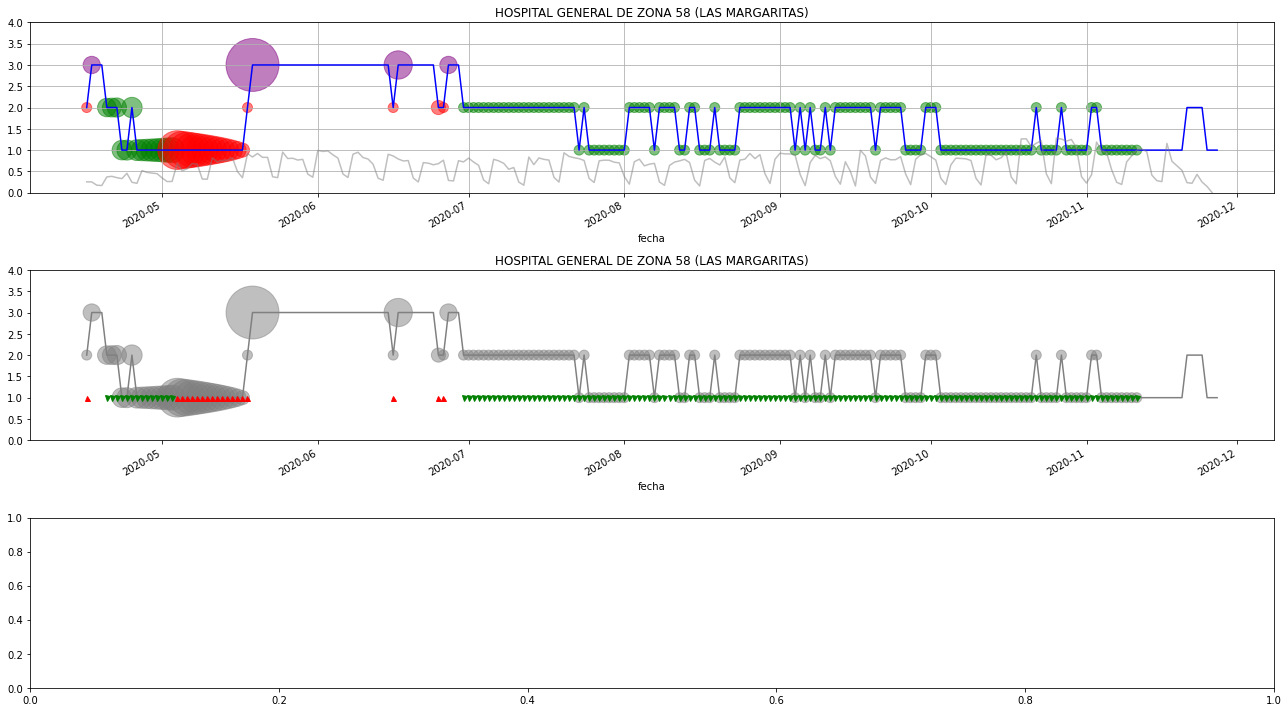

In [13]:
fig, ax = plt.subplots(3, 1, figsize=(18, 10))

hospital_timeline.plot_hospital_timeline(
    hospital_name, 
    ax[0], 
    target_name=target_name)

hospital_timeline.plot_hospital_timeline(
    hospital_name, 
    ax[1],
    gray=True,
    target_name=target_name)

neighbor_municipios_daily_cases = neighbor_municipios_daily_cases.loc[
    data[data['nombre_hospital'] == hospital_name]['fecha'].min():
    data[data['nombre_hospital'] == hospital_name]['fecha'].max()]

covid_cases = neighbor_municipios_daily_cases.sum(axis=1)

(covid_cases / 700).plot(
    ax=ax[0],
    alpha=.5,
    grid=True,
    color='gray')

dataset_hospital.query('%s == 1' % target_name)[target_name].plot(
    ax=ax[1],
    color='red',
    marker='^',
    markersize=5,
    linestyle='')

(dataset_hospital.query('%s == 0' % target_name)[target_name] + 1).plot(
    ax=ax[1],
    color='green',
    marker='v',
    markersize=5,
    linestyle='')

fig.set_tight_layout('tight')

In [14]:
dataset

,fecha,contagios_abs_energy,contagios_absolute_sum_of_changes,contagios_count_above_mean,contagios_count_below_mean,contagios_kurtosis,contagios_maximum,contagios_mean,contagios_mean_abs_change,contagios_mean_change,...,is_next_peak_in_20_days,is_next_peak_in_30_days,nombre_hospital,neighbor_hosp_num_hospitals_around,neighbor_hosp_max_capacity_percent,neighbor_hosp_min_capacity_percent,neighbor_hosp_mean_capactity_percent,neighbor_hosp_mean_capacity_slope,neighbor_hosp_mean_std_capactity_percent,neighbor_hosp_mean_median_capactity_percent
0,2020-04-15,504.0,54.0,21.0,84.0,7.830765,10.0,0.819048,0.519231,0.076923,...,0.0,1.0,ALTA ESPECIALIDAD DE ZUMPANGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-04-16,553.0,55.0,22.0,84.0,6.651405,10.0,0.877358,0.523810,0.066667,...,0.0,1.0,ALTA ESPECIALIDAD DE ZUMPANGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-04-17,589.0,56.0,23.0,84.0,5.814985,10.0,0.925234,0.528302,0.056604,...,0.0,1.0,ALTA ESPECIALIDAD DE ZUMPANGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-04-19,654.0,60.0,21.0,88.0,4.705789,10.0,1.009174,0.555556,0.037037,...,0.0,1.0,ALTA ESPECIALIDAD DE ZUMPANGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-04-20,735.0,65.0,22.0,88.0,4.201516,10.0,1.081818,0.596330,0.082569,...,1.0,1.0,ALTA ESPECIALIDAD DE ZUMPANGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10584,2020-11-14,95149303.0,41176.0,151.0,167.0,-0.830734,1360.0,413.531447,129.892744,2.757098,...,1.0,1.0,UNIDAD MÓVIL TEMPORAL COVID,4.0,100.0,49.0,67.915888,-0.095327,15.632252,65.0
10585,2020-11-15,95353607.0,41598.0,152.0,167.0,-0.824543,1360.0,413.652038,130.811321,1.421384,...,1.0,1.0,UNIDAD MÓVIL TEMPORAL COVID,4.0,100.0,49.0,67.827907,-0.132093,15.668586,65.0
10586,2020-11-16,95432568.0,41769.0,152.0,168.0,-0.817619,1360.0,413.237500,130.937304,0.880878,...,1.0,1.0,UNIDAD MÓVIL TEMPORAL COVID,4.0,100.0,49.0,67.777778,-0.094444,15.669544,65.0
10587,2020-11-17,95484552.0,41822.0,152.0,169.0,-0.811576,1360.0,412.660436,130.693750,0.712500,...,1.0,1.0,UNIDAD MÓVIL TEMPORAL COVID,4.0,100.0,49.0,67.728111,-0.094009,15.670017,65.0


In [15]:
dataset_hospital['neighbor_hosp_num_hospitals_around']

fecha
2020-04-16    NaN
2020-04-20    5.0
2020-04-21    5.0
2020-04-22    5.0
2020-04-23    5.0
             ... 
2020-11-07    5.0
2020-11-08    5.0
2020-11-09    5.0
2020-11-10    5.0
2020-11-11    NaN
Name: neighbor_hosp_num_hospitals_around, Length: 168, dtype: float64